In [2]:
# 1.1 – Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1.2 – Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

file_path = r"C:\Users\acer\Downloads\Hospital Data.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


Shape: (15757, 56)


,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,duration of intensive unit stay,OUTCOME,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,BNP,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,2,DISCHARGE,0,0,1,0,0,0,0,9.5,16.1,337,80,34,0.9,1880,1,35,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,2,DISCHARGE,0,1,0,1,1,0,0,13.7,9,149,112,18,0.9,NaN,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,3,DISCHARGE,0,0,1,0,1,0,0,10.6,14.7,329,187,93,2.3,210,0,NaN,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,6,DISCHARGE,0,0,0,1,1,0,0,12.8,9.9,286,130,27,0.6,NaN,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,9,DISCHARGE,0,0,0,1,0,1,0,13.6,9.1,26,144,55,1.25,1840,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# 2.1 – Normalize/parse dates (mm/dd/yyyy). Strip any time parts if present.
for c in ["D.O.A", "D.O.D"]:
    if c in df.columns:
        df[c] = (
            df[c].astype(str)
                 .str.split().str[0]                         # drop time part if any
                 .str.replace(r"[^0-9/]", "", regex=True)    # keep only digits and '/'
        )
        df[c] = pd.to_datetime(df[c], format="%m/%d/%Y", errors="coerce")

# 2.2 – Compute inclusive stay: 04/01 → 04/03 = 3 days
df["DURATION_OF_STAY"] = (df["D.O.D"].dt.normalize() - df["D.O.A"].dt.normalize()).dt.days + 1

# 2.3 – Basic sanity checks
print(df[["D.O.A","D.O.D","DURATION_OF_STAY"]].head(10))
print(df["DURATION_OF_STAY"].describe())

# 2.4 – Drop obviously invalid rows (<=0 or insanely long stays; tweak max if needed)
df = df[(df["DURATION_OF_STAY"] > 0) & (df["DURATION_OF_STAY"] <= 120)].copy()


       D.O.A      D.O.D  DURATION_OF_STAY
0 2017-04-01 2017-04-03               3.0
1 2017-04-01 2017-04-05               5.0
2 2017-04-01 2017-04-03               3.0
3 2017-04-01 2017-04-08               8.0
4 2017-04-01 2017-04-23              23.0
5 2017-04-01 2017-04-10              10.0
6 2017-04-01 2017-04-06               6.0
7 2017-04-01 2017-04-13              13.0
8 2017-04-01 2017-04-03               3.0
9 2017-04-01 2017-04-03               3.0
count    8632.000000
mean       32.267493
std        59.142432
min      -332.000000
25%         3.000000
50%         7.000000
75%        31.000000
max       335.000000
Name: DURATION_OF_STAY, dtype: float64


In [6]:
# Example mappings (only if these columns exist in your file)
if "GENDER" in df.columns:
    df["GENDER"] = df["GENDER"].astype(str).str.strip().str.upper().replace({
        "M":"MALE", "F":"FEMALE"
    })

if "RURAL" in df.columns:
    df["RURAL"] = df["RURAL"].astype(str).str.strip().str.upper().replace({
        "R":"RURAL", "U":"URBAN"
    })

if "TYPE OF ADMISSION-EMERGENCY/OPD" in df.columns:
    df["TYPE OF ADMISSION-EMERGENCY/OPD"] = df["TYPE OF ADMISSION-EMERGENCY/OPD"].astype(str).str.strip().str.upper().replace({
        "E":"EMERGENCY", "O":"OPD"
    })


In [7]:
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    conv = pd.to_numeric(df[col], errors="coerce")
    if conv.notna().mean() > 0.5:   # if >50% values are numeric
        df[col] = conv


In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number, "datetime64[ns]"]).columns

for col in num_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])


In [9]:

df = df.drop_duplicates().reset_index(drop=True)

In [10]:

df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   SNO                              7588 non-null   int64         
 1   MRD No.                          7588 non-null   int64         
 2   D.O.A                            7588 non-null   datetime64[ns]
 3   D.O.D                            7588 non-null   datetime64[ns]
 4   AGE                              7588 non-null   int64         
 5   GENDER                           7588 non-null   object        
 6   RURAL                            7588 non-null   object        
 7   TYPE OF ADMISSION-EMERGENCY/OPD  7588 non-null   object        
 8   month year                       7588 non-null   object        
 9   DURATION OF STAY                 7588 non-null   int64         
 10  duration of intensive unit stay  7588 non-null   int64      

,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,duration of intensive unit stay,OUTCOME,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,HB,TLC,PLATELETS,GLUCOSE,UREA,CREATININE,BNP,RAISED CARDIAC ENZYMES,EF,SEVERE ANAEMIA,ANAEMIA,STABLE ANGINA,ACS,STEMI,ATYPICAL CHEST PAIN,HEART FAILURE,HFREF,HFNEF,VALVULAR,CHB,SSS,AKI,CVA INFRACT,CVA BLEED,AF,VT,PSVT,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,DURATION_OF_STAY
count,7588.000000,7.588000e+03,7588,7588,7588.000000,7588,7588,7588,7588,7588.000000,7588.000000,7588,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.00000,7588.000000,7588.000000,7588.000000,7588.000000
unique,NaN,NaN,NaN,NaN,NaN,2,2,2,24,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,MALE,URBAN,EMERGENCY,Nov-17,NaN,NaN,DISCHARGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,4865,5587,4967,722,NaN,NaN,6066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4944.821956,3.466533e+05,2017-12-01 17:13:18.945703936,2017-12-15 05:04:46.557722624,60.986294,NaN,NaN,NaN,NaN,5.681603,3.311017,NaN,0.062994,0.084475,0.387454,0.480364,0.586057,0.176463,0.095941,12.366210,11.729643,232.250245,160.177807,50.254373,1.366962,NaN,0.184502,42.404718,0.014233,0.158276,0.089615,0.345150,0.145493,0.027939,0.271481,0.185688,0.086584,0.045203,0.021613,0.008171,0.242093,0.043885,0.007116,0.070111,0.036110,0.006721,0.015551,0.068661,0.010411,0.004613,0.001977,0.010675,0.10912,0.090142,0.017396,0.021481,14.494070
min,1.000000,5.060000e+02,2017-01-04 00:00:00,2017-01-12 00:00:00,4.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.100000,0.580000,1.200000,0.100000,0.100000,NaN,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
25%,1915.750000,2.598670e+05,2017-07-10 00:00:00,2017-07-16 00:00:00,53.000000,NaN,NaN,NaN,NaN,3.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.900000,8.000000,169.000000,108.000000,26.000000,0.800000,NaN,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3.000000
50%,3894.500000,3.374305e+05,2017-10-24 00:00:00,2017-10-29 00:00:00,62.000000,NaN,NaN,NaN,NaN,4.000000,2.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.500000,10.200000,222.000000,136.000000,35.000000,1.000000,NaN,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000

In [11]:
# Daily admissions count
daily_counts = df.groupby("D.O.A").size().reset_index(name="admissions")

# Weekly admissions count (ISO weeks)
weekly_counts = df.groupby(pd.Grouper(key="D.O.A", freq="W")).size().reset_index(name="admissions")

print(daily_counts.head())
print(weekly_counts.head())

       D.O.A  admissions
0 2017-01-04           1
1 2017-01-11           2
2 2017-01-12           3
3 2017-02-04           2
4 2017-02-10           2
       D.O.A  admissions
0 2017-01-08           1
1 2017-01-15           5
2 2017-01-22           0
3 2017-01-29           0
4 2017-02-05           2


In [12]:
daily_counts = daily_counts.set_index("D.O.A").asfreq("D")  # ensure daily frequency
weekly_counts = weekly_counts.set_index("D.O.A").asfreq("W")  # ensure weekly frequency

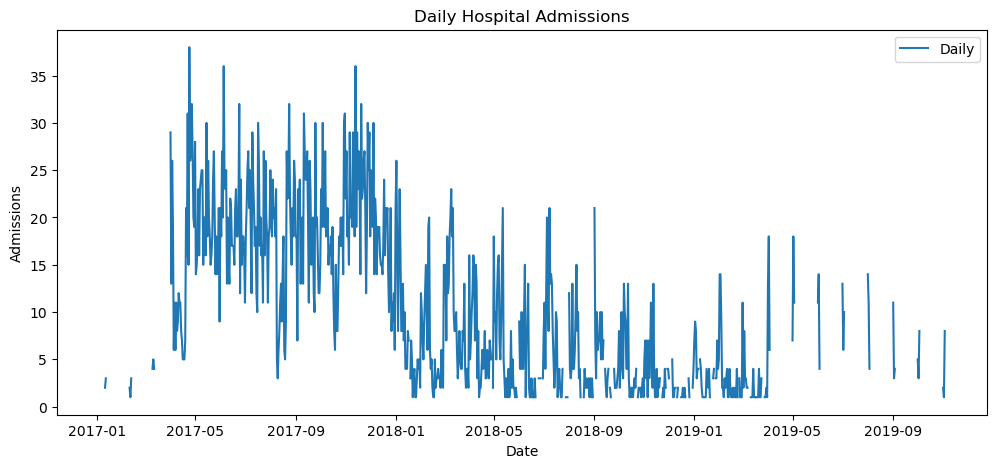

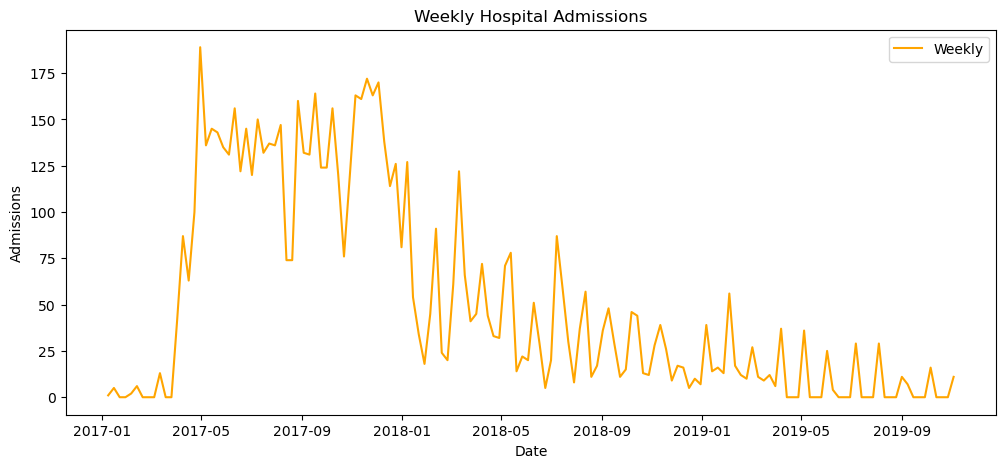

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_counts.index, daily_counts["admissions"], label="Daily")
plt.title("Daily Hospital Admissions")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(weekly_counts.index, weekly_counts["admissions"], label="Weekly", color="orange")
plt.title("Weekly Hospital Admissions")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.show()


In [14]:
train_size = int(len(weekly_counts) * 0.8)
train, test = weekly_counts.iloc[:train_size], weekly_counts.iloc[train_size:]

In [15]:
import pmdarima as pm

# Auto-ARIMA (it will choose best p,d,q)
arima_model = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)

print(arima_model.summary())


C:\Users\acer\anaconda3\envs\timeseries\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\acer\anaconda3\envs\timeseries\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\acer\anaconda3\envs\timeseries\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\acer\anaconda3\envs\timeseries\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\acer\anaconda3\envs\timeseries\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  118
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -550.392
Date:                Mon, 18 Aug 2025   AIC                           1108.784
Time:                        17:36:36   BIC                           1119.833
Sample:                    01-08-2017   HQIC                          1113.270
                         - 04-07-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3471      0.090     -3.842      0.000      -0.524      -0.170
ar.L2         -0.4193      0.081     -5.207      0.000      -0.577      -0.261
ar.L3         -0.2024      0.080     -2.542      0.0

C:\Users\acer\anaconda3\envs\timeseries\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\acer\anaconda3\envs\timeseries\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


C:\Users\acer\anaconda3\envs\timeseries\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Hybrid MAE: 15.45, RMSE: 17.36


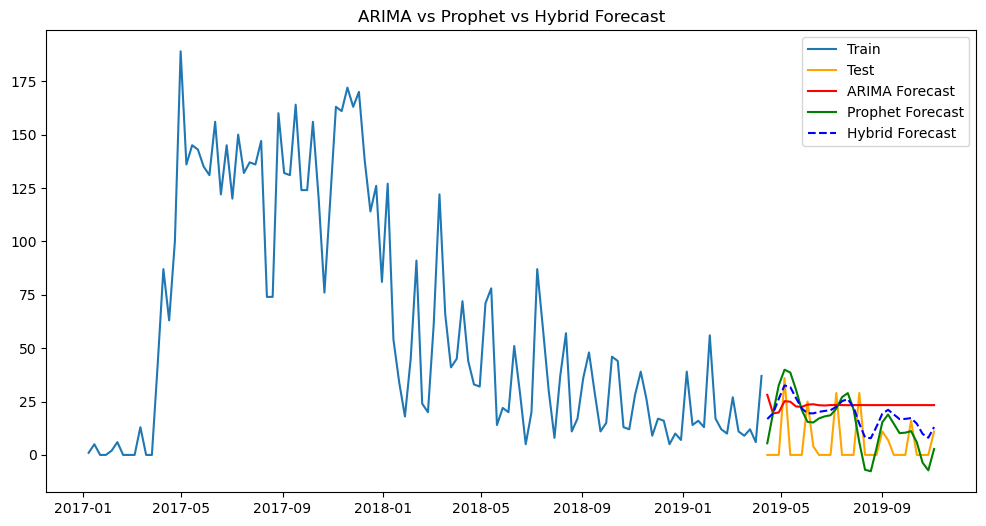

In [27]:
# -------------------------
# Step 1: ARIMA Forecast
# -------------------------
n_test = len(test)
arima_forecast = arima_model.predict(n_periods=n_test)

# Convert to Series with same index as test
arima_forecast = pd.Series(arima_forecast, index=test.index)

# For hybrid later
arima_pred = arima_forecast.values  

# -------------------------
# Step 2: Prophet Forecast
# -------------------------
# Prophet forecast already stored in `forecast`
prophet_pred = forecast.set_index("ds").loc[prophet_test["ds"], "yhat"].values  

# -------------------------
# Step 3: Hybrid Forecast (average of ARIMA + Prophet)
# -------------------------
hybrid_pred = (arima_pred + prophet_pred) / 2

# -------------------------
# Step 4: Evaluation
# -------------------------
mae_hybrid = mean_absolute_error(test, hybrid_pred)
rmse_hybrid = np.sqrt(mean_squared_error(test, hybrid_pred))

print(f"Hybrid MAE: {mae_hybrid:.2f}, RMSE: {rmse_hybrid:.2f}")

# -------------------------
# Step 5: Plot results
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(arima_forecast, label="ARIMA Forecast", color="red")
plt.plot(prophet_test["ds"], prophet_pred, label="Prophet Forecast", color="green")
plt.plot(test.index, hybrid_pred, label="Hybrid Forecast", color="blue", linestyle="--")
plt.legend()
plt.title("ARIMA vs Prophet vs Hybrid Forecast")
plt.show()


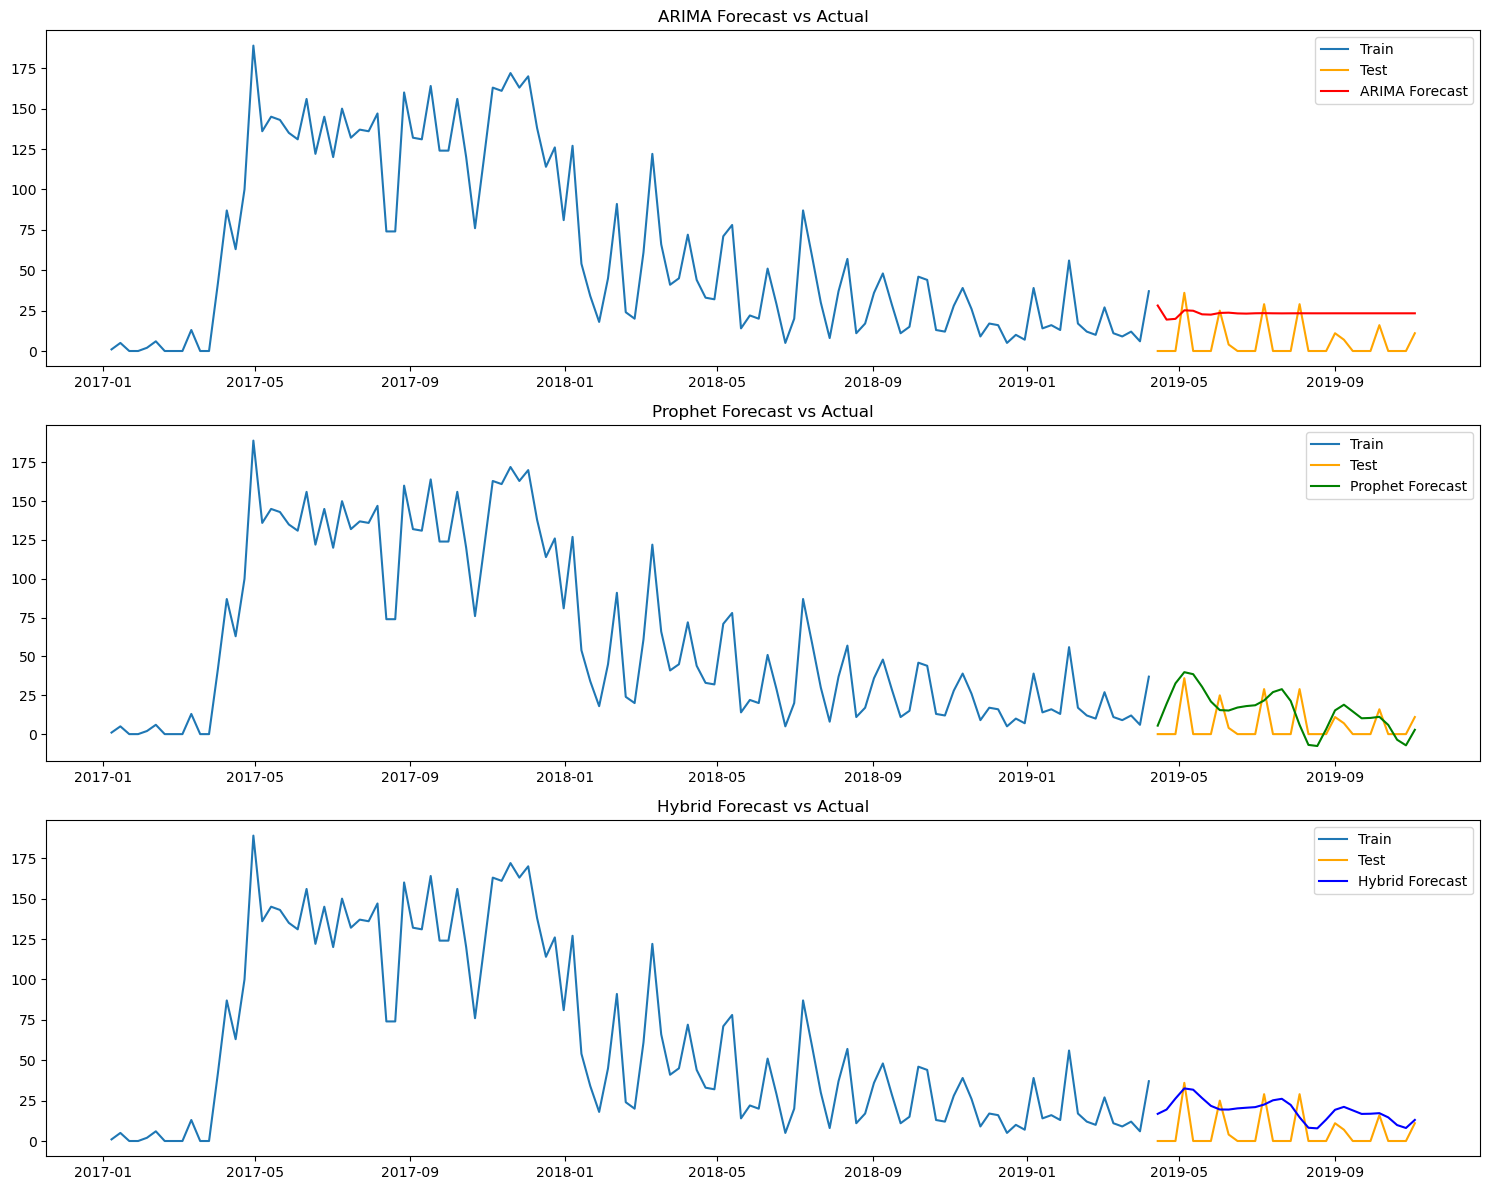

In [28]:
plt.figure(figsize=(15,12))

# -------------------------
# Plot 1: ARIMA
# -------------------------
plt.subplot(3,1,1)
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(arima_forecast, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast vs Actual")

# -------------------------
# Plot 2: Prophet
# -------------------------
plt.subplot(3,1,2)
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(prophet_test["ds"], prophet_pred, label="Prophet Forecast", color="green")
plt.legend()
plt.title("Prophet Forecast vs Actual")

# -------------------------
# Plot 3: Hybrid
# -------------------------
plt.subplot(3,1,3)
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(test.index, hybrid_pred, label="Hybrid Forecast", color="blue")
plt.legend()
plt.title("Hybrid Forecast vs Actual")

plt.tight_layout()
plt.show()




In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# -------------------------
# 1. ARIMA Evaluation
# -------------------------
mae_arima = mean_absolute_error(test, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))

# -------------------------
# 2. Prophet Evaluation
# -------------------------
prophet_pred = forecast.set_index("ds").loc[prophet_test["ds"], "yhat"].values
mae_prophet = mean_absolute_error(prophet_test["y"], prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(prophet_test["y"], prophet_pred))

# -------------------------
# 3. Hybrid Evaluation (Average of ARIMA + Prophet)
# -------------------------
hybrid_pred = (arima_forecast.values + prophet_pred) / 2
mae_hybrid = mean_absolute_error(test, hybrid_pred)
rmse_hybrid = np.sqrt(mean_squared_error(test, hybrid_pred))

# -------------------------
# Results in Table
# -------------------------
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "Hybrid"],
    "MAE": [mae_arima, mae_prophet, mae_hybrid],
    "RMSE": [rmse_arima, rmse_prophet, rmse_hybrid]
})

print(results)



     Model        MAE       RMSE
0    ARIMA  19.294724  20.458856
1  Prophet  14.431871  17.359550
2   Hybrid  15.449726  17.358364


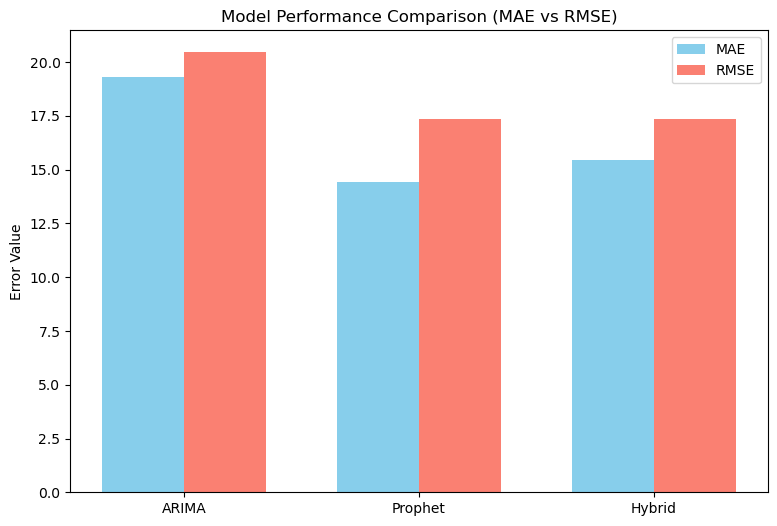

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ["ARIMA", "Prophet", "Hybrid"]
mae = [19.294724, 14.431871, 15.449726]
rmse = [20.458856, 17.359550, 17.358364]

x = np.arange(len(models))  # Model positions
width = 0.35  # Bar width

# Plot
plt.figure(figsize=(9,6))
plt.bar(x - width/2, mae, width, label="MAE", color="skyblue")
plt.bar(x + width/2, rmse, width, label="RMSE", color="salmon")

# Formatting
plt.xticks(x, models)
plt.ylabel("Error Value")
plt.title("Model Performance Comparison (MAE vs RMSE)")
plt.legend()
plt.show()



In [32]:
prophet_pred = forecast.set_index("ds").loc[prophet_test["ds"], "yhat"].values.flatten()



In [33]:
arima_forecast = pd.Series(arima_forecast.values.flatten(), index=test.index)


In [34]:
hybrid_pred = (arima_forecast.values + prophet_pred) / 2


In [36]:
# Ensure everything is 1-D
actual = test.values.flatten()
arima_pred = arima_forecast.values.flatten()
prophet_pred = prophet_pred.flatten()
hybrid_pred = hybrid_pred.flatten()


In [39]:
results_df = pd.DataFrame({
    "Date": test.index,
    "Actual": actual,
    "ARIMA_Forecast": arima_pred,
    "Prophet_Forecast": prophet_pred,
    "Hybrid_Forecast": hybrid_pred
})
output_path = r"C:\Users\acer\Downloads\model_forecasts.csv"
results_df.to_csv(output_path, index=False)
print("✅ Forecast results saved to model_forecasts.csv")


✅ Forecast results saved to model_forecasts.csv
